**![](http://)# Car Price prediction - 2

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline (взятом за основу решения) было сделано следующее:
* Построена "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Частично обработаны и отнормированы признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

## Какие дополнения внесены в мое решение:

* Добавлены и отнормированы признаки, касающиеся характеристик автомобиля.  
  Переведены в числовые значения мощность и объем двигателя, количество дверей, количество владельцев, время владения автомобилем.  
  Также опробовано логарифмирование таргета (цены) - так как распределение цены похоже на логнормальное, то при взятии логарифма, распределение будет похоже на нормальное. В теории нейросети должны показывать лучший результат, однако на практике это привело только к улучшению модели CatBoost, а для нейронной сети результат сильно ухудшился. Не исключено, что в коде была допущена ошибка, но для построения pipeline и получения конечного результата для нейросетей таргет остался в исходном виде
* Проведена работа по очистке текстового описания автомобиля: из текста удалены стоп-слова, проведена лемматизация текста. Из полученного в результате этих преобразований текста выделены 50 наиболее часто встречающихся блоков текста, и наличие таких блоков в описании добавлено в качестве дополнительного признака.
* В результате первая модель на основе градиентного бустинга (CatBoost) на подготовленных данных дала очень хороший результат - на тестовой выборке **MAPE = 10.96%** (скор на каггл = **12,12390**)
* Вторая модель на основе нейронных сетей дала результат на тестовой выборке 12,61% (хуже CatBoost)  
* Multi-input нейронная сеть для анализа табличных данных и текста одновременно. Тут были опробованы:
 - небольшие изменения в архитектуре - замена слоев LSTM на RNN, давало незначительное улучшение, например, от 12,51% до 12,41% при прочих равных условиях (цифры без лемматизации);
 - использовались подготовленные текстовые описания, но лемматизация приводила даже к ухудшению результатов (до 13%);
 - по условиям задачи опробован transfer lerning: сначала обучена сеть только для NLP (NLP NN), и потом уже предобученная сеть NLP NN подавалаcь в качестве второго входа в мульти-инпут сеть, состоящую из нейросети на табличных данных (TabularNN) и нейросети на основе NPL (NLP NN).
 - Результат обучения только сети NLP NN (т.е. предсказание цены на основе ТОЛЬКО текстового описания продавца) довольно устойчиво достигла MAPE 50%. Это лучше, чем предсказание по медианной цене для все выборки (точность 60%), то есть какую-то полезную информацию из описания можно получить.
 - Результат такого обучения с transfer learning:  12.73%,это чуть лучше, чем для такой же сети с учетом лемматизации текста. Но проведенных экспериментов недостаточно для того, чтобы сделать вывод об улучшении, ухудшении или отсутствии влияния на модель данной техники.

* Третья нейронная сеть:  multi-input сеть, к табличным данным и тексту добавлены изображения:
 - так как вторая сеть для текстовых данных не показала однозначных преимуществ предобучения, то часть с тектовыми данными была оставлена, как есть в бейзлайне
 - по условиям задачи опробован transfer learning + finetuning для нейронной сети с обработкой изображений
 - для анализа изображений и предсказания цены по фотографии использована сеть EfficientNetB3 с предобученными на ImageNet весами
 - при аугментации изображений увеличен диапазон изменения яркости, контраста и насыщенности
 - обучение такой сети (предсказание цены автомобиля по фото) дало MAPE =33%, (что гораздо лучше 50% при предсказании только по текстовому описанию из второй сети)
 - далее при составлении multi-input сети возьмем предобученную на предыдущем шаге сеть для изображений и заморозим примерно половину входных слоев: это должно позводлить сократить время обучения и сохранить полученные на предыдущем этапе признаки.
 - результат этой мульти-инпут сети: TEST mape: 13.70%
* Ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний) дало наилучший результат: на тестовой выборке **MAPE = 10.88%** (скор на каггл = **11,76884**)


## Выводы:
* Примененные приемы помогли улучшить результат
* Основной целью было создание минимально работающего пайплайна и принципиальное опробование различных техник работы с multi-input NN
* Catboost работает лучше всего, но блендинг CatBoost с результатом нейросети тоже немного улучшает результат

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 8.2 MB 6.9 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import string



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


#### дополнительно к бейзлайну импорт в моем решении
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
import collections
import pymorphy2

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
# вспомогательная функция для вычисления средней абсолютной процентной ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)/y_true)

In [7]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
test['brand'].unique()

array(['MERCEDES', 'BMW', 'AUDI'], dtype=object)

In [11]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


In [14]:
# Наивная модель для предсказания на каггл:
predicts = []
for index, row in pd.DataFrame(test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#предсказание
sample_submission['price'] = predicts
sample_submission.to_csv('naive_submission.csv', index=False)

In [15]:
# И еще посмотрим, какая будет ошибка, если предсказатть цену = медианное по всей выборке
prediction_median = np.full(len(data_test['price']), data_train['price'].median())
print(f"Если предсказать медианное, метрика MAPE: {(mape(data_test['price'], prediction_median))*100:0.2f}%")
# предсказание = среднее
prediction_mean = np.full(len(data_test['price']), data_train['price'].mean())
print(f"Если предсказать среднее, метрика MAPE: {(mape(data_test['price'], prediction_mean))*100:0.2f}%")

Если предсказать медианное, метрика MAPE: 64.76%
Если предсказать среднее, метрика MAPE: 102.94%


In [16]:
sample_submission.head(10)

,sell_id,price
0,1099427284,1312000.0
1,1096405886,2200000.0
2,1100195294,620000.0
3,1099827282,540000.0
4,1100076198,2972000.0
5,1090159352,2349000.0
6,1098987386,1505000.0
7,1098639040,1550000.0
8,1099933039,1293000.0
9,1099565572,520000.0


# EDA

Посмотрим, как выглядят распределения числовых признаков:

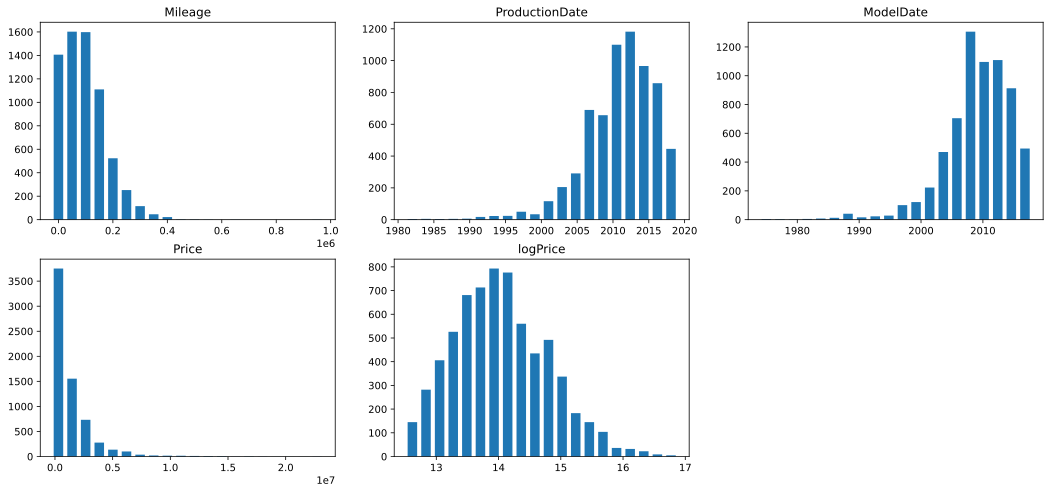

In [17]:
# Посмотрим, как выглядят распределение числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i+1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({'Mileage': train['mileage'].dropna(),
              'ProductionDate' : train['productionDate'].dropna(),
              'ModelDate': train['modelDate'].dropna(),
              'Price': train['price'],
              'logPrice': np.log(train['price'])})

Итого:
* Признаки mileage, а также productionDate и modelDate после преобразования типа (2021 - Date) - похожи на логнормальные с правым хвостом. Имеет смысл взять от них логарифм
* Логарифм от таргета - тоже похож на нормальное распределение, но это будем использовать только для CatBoost (для нейросети не дало результатов)
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [18]:
# В предобработке переведем мощнось и объем двигателя в числовые, поэтому сразу отнесем их к числовым: 'engineDisplacement', 'enginePower'
# Числовеы данные, записанные в numerical_features - приведем к масштабу от 0 до 1 с помощью MinMaxScaler
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
   'vehicleTransmission', 'ПТС', 'Привод', 'Руль']
numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'possession', 'Владельцы',
                     'numberOfDoors']


In [19]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [20]:
# Вспомогательные функции для перевода в числовое значение поля "Владение"
def possession(value_str):
    value_str = value_str.split()
    if len(value_str) == 5:
        return 12 * int(value_str[0]) + int(value_str[3])
    elif value_str[1].startswith('меся'):
        return int(value_str[0])
    else:
        return 12 * int(value_str[0])
    

def posssession_nan(year):
    
    return data[(data['productionDate'] == year) & (~data['possession'].isna())]['possession'].median()


def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # my: 
    # в явном виде переводим в целочисленный тип объем двигателя и мощность
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x[:-4]))
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: 
                                                                            0 if x == 'undefined LTR' else 10 * float(x[:-4]))

    # Количество владельцев переведем в число:
    df_output['Владельцы'].fillna(df_output['Владельцы'].value_counts().index[0], inplace = True)
    df_output['Владельцы'] = df_output['Владельцы'].apply(lambda x: int(x[:1]))
    
    # Количество дверей переведем в число, ПРИ ЭТОМ НЕ БУДЕМ НОРМИРОВАТЬ - поэтому признак отсутствует в обоих списках (категориальных и фисловых фич)
    df_output['numberOfDoors'] = df_output['numberOfDoors'].apply(int)
    
    ################   Признак "Владение"   #############################################################
    # Переведем в числовое значение поле "Владение" и запишем его в столбец "possession"
    # для строк, где указан параметр "Владение":
    df_output['possession'] = df_output[~df_output['Владение'].isna()]['Владение'].apply(lambda x: possession(x))
    # Теперь составим датафрейм, где индекс - это год выпуска, а значение - медиана "владения" для данного года выпуска
    median_possession = df_output.groupby('productionDate')['possession'].median()
    
    df_output.loc[df_output['Владение'].isna(),'possession'] = df_output[
                                df_output['Владение'].isna()]['productionDate'].apply(lambda x: median_possession.loc[x])
    df_output['possession'].fillna(method = 'bfill', inplace = True)
    df_output.drop(['Владение'], axis = 1, inplace=True) # удалим колонку "Владение", тк все перенесли в 'possession'

    
    #   Приведем к нормальному распределению данные: 'enginePower', mileage, possession,
    
    for col in ['enginePower', 'mileage', 'possession']:
        df_output[col] = np.log(df_output[col])
    #  Данные с годами производства больше похожи на зеркальное отражение логнормального распределения,
    #  поэтому для них сделаем по-другому, и вычтем из 2021 - чтобы исключить нули
    df_output['productionDate'] = np.log(2021 - df_output['productionDate'])
    df_output['modelDate'] = np.log(2021 - df_output['modelDate'])
    
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        
    # выделим drivex как отднльный признак
    df_output['drivex'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in str(x) else 0)
    
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    df_output.drop(['name'], axis = 1, inplace=True)
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [21]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,sample,price,possession,...,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.30303,0.529985,0.838231,0.389193,1.0,0.489076,0.0,1,1590000.0,0.688517,...,0,0,0,0,1,0,0,1,1,0


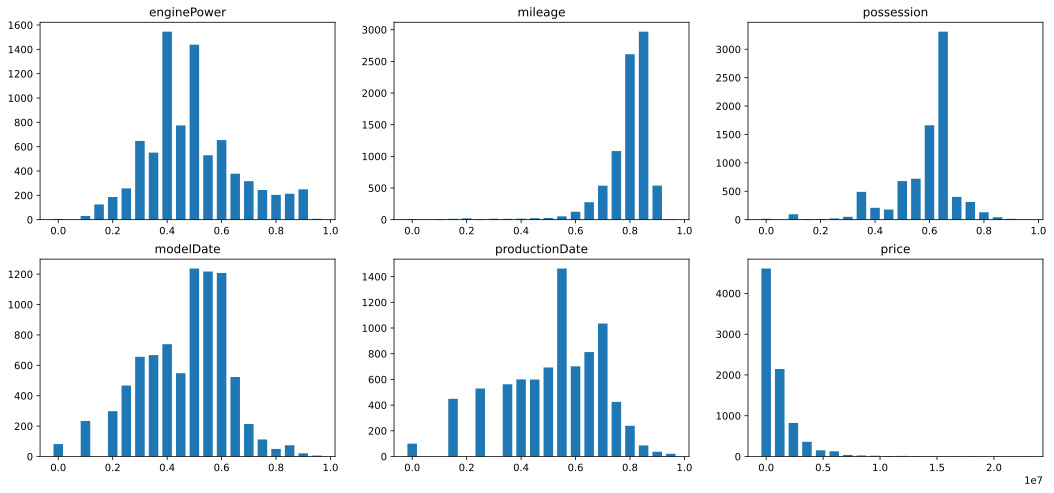

In [22]:
data_to_visualize = {
    'enginePower': df_preproc['enginePower'],
    'mileage': df_preproc['mileage'],
    'possession': df_preproc['possession'],
    'modelDate' : df_preproc['modelDate'],
    'productionDate' : df_preproc['productionDate'],
    'price' : df_preproc['price'],
}
visualize_distributions(data_to_visualize)

# Видим, что после взятия логарифма распрееление признаков больше похоже на нормальное.
# Теоретически цену тоже можно прологарифмировать, но по факту это только ухудшает результат на нейронных сетях

## Очистка текста

проведем очистку поля "описание".
Сделаем 2 вещи:
1. уберем стоп-слова, знаки препинания и сделаем лемматизацию текста. Это нам поможет в нейросетке с обработкой языка
2. выделим часто встречающиеся блоки текста (50 наиболее частых) и запишем их наличие в отдельный признак. Это будет нужно для катбуста и табличной сети

In [23]:
stop_words = set(stopwords.words('russian'))|set(['•']) - set(['не', 'только', 'без', 'почти', 'всего', 'хорошо', 'никогда', 'больше',
                                                   'один'])

In [24]:
## 1 -  убираем стоп-слова и проводим лемматизацию текста
morph = pymorphy2.MorphAnalyzer()

def clean_text(text):
    # Функция для обработки одного описания к автомобилю
    
   
    # Разбиваем текст по пробельным символам и по знакам препинания
    text = regexp_tokenize(text, r'[\s\.\?!",():;\-\n]\s*', gaps=True)
    
    # Удаляем слова, состоящие из цифр и стоп-слова
    # TODO еще можно ТО заменить на "техобслуживание" - потому как в текущей версии ТО станет "то" и вообще удалится
    text = [w for w in text if (w not in stop_words) and (not w.isdigit())]
    
    #лемматизация
    text = [morph.parse(w)[0].normal_form for w in text]
    
    text = ' '.join(text)
    # приводим все к нижнему регистру
    text = text.lower()

    
    return text


In [25]:
data['description'] = data['description'].apply(clean_text)

In [26]:
# 2 - выделим 50 часто встречающизся блоков текста и переведем его в табличные признаки в df_preproc

In [27]:
all_words = collections.Counter()
for text in data.description.values:
    for word in text.split():
        all_words[word] += 1

In [28]:
# выделяем наиболее частые блоки текста
most_common_words = dict(all_words.most_common(1000))

def func_text_blocks(corpus):
    text_blocks = collections.Counter()
    # организуем цикл по всем предложениям
    for sent in corpus:
        sent_split = sent.split() # представляем предложение в виде списка слов
        #print(' ----- Читаю предложение: --------')
        #print(sent_split)
        i = 0 
        # организуем цикл while по предложению, и будем добавлять слова в фразу, если они из частых
        while i < len(sent_split):
            text_block = sent_split[i]
            if sent_split[i] in most_common_words.keys():
                text_block = sent_split[i]
                find_text_block = False
                #print(' ------ Ого! Я нашел частое слово: ------', sent_split[i])
                while (i + 1 < len(sent_split)) and (sent_split[i + 1] in most_common_words.keys()):
                    text_block += ' ' + sent_split[i + 1]
                    #print( '     дальше тоже частое слово :::::::::', text_block)
                    find_text_block = True
                    i += 1
                if find_text_block: text_blocks[text_block] += 1
            i += 1
    return text_blocks

text_blocks = func_text_blocks(data.description.values)

In [29]:
# Посмотрим, какие блоки текста наиболее часто встречаются в описаниях
text_blocks.most_common(50)

[('connected drive services', 165),
 ('уникальный код автомобиль', 142),
 ('mercedes benz', 130),
 ('avilon автомобиль пробег – это обслуживание предпродажный подготовка сертифицированный сервисный станция предоставление официальный диагностика обязательный юридический проверка автомобиль обеспечивать полный прозрачность сервисный история исключать наличие финансовый обременение купить продать любой авто официально avilon автомобиль пробег позвонить мы узнать подробный #cme44 ти',
  117),
 ('выгода руб обмен ваш автомобиль выгода покупка кредит руб рольф', 113),
 ('автоматический включение дальний свет', 112),
 ('управление страна россия', 112),
 ('пробег мы принимать любой легковой коммерческий автомобиль независимо марка год выпуск пробег состояние автомобиль в наличие проверить готовый продажа автомобиль более комплект шина диск колесо сбор всё автомобиль проходить комплексный проверка технический криминалистический проверка история кузовной ремонт сертифицированный специалист мы пр

In [30]:
# К табличным данным добавим сведения о наличии в описании часто встречающихся блоков текста
for i, text in enumerate(text_blocks.most_common(50)):
    column = 't_block' + str(i)
    df_preproc[column] = data['description'].apply(lambda x: 1 if text[0] in str(x) else 0)

In [31]:
df_preproc.sample()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,sample,price,possession,...,t_block40,t_block41,t_block42,t_block43,t_block44,t_block45,t_block46,t_block47,t_block48,t_block49
3640,0.30303,0.439126,0.891384,0.581508,1.0,0.700125,0.0,1,630000.0,0.840323,...,0,0,0,0,0,0,0,0,0,0


## Split data

In [32]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет 
# При экспериментах проводились попытки прологарифмировать таргет, но это дало улучшение только для CatBoost.
# Поэтому таргет оставим неизменным, а логарифм возьмем только для CatBoost.
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 233 entries, engineDisplacement to t_block49
dtypes: float64(9), int64(51), uint8(173)
memory usage: 1.1 MB


# Model 2: CatBoostRegressor

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [35]:
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          #learning_rate = 0.05,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.015242
0:	learn: 0.0421406	test: 0.0422023	best: 0.0422023 (0)	total: 59.9ms	remaining: 9m 58s
100:	learn: 0.0166152	test: 0.0161650	best: 0.0161650 (100)	total: 589ms	remaining: 57.8s
200:	learn: 0.0117013	test: 0.0113482	best: 0.0113482 (200)	total: 1.09s	remaining: 53.2s
300:	learn: 0.0104688	test: 0.0101713	best: 0.0101713 (300)	total: 1.57s	remaining: 50.7s
400:	learn: 0.0099852	test: 0.0097563	best: 0.0097563 (400)	total: 2.04s	remaining: 48.9s
500:	learn: 0.0097427	test: 0.0095557	best: 0.0095557 (500)	total: 2.54s	remaining: 48.1s
600:	learn: 0.0094806	test: 0.0093606	best: 0.0093606 (600)	total: 3s	remaining: 47s
700:	learn: 0.0092739	test: 0.0092209	best: 0.0092209 (700)	total: 3.46s	remaining: 46s
800:	learn: 0.0090227	test: 0.0090489	best: 0.0090489 (800)	total: 3.93s	remaining: 45.1s
900:	learn: 0.0088062	test: 0.0089096	best: 0.0089096 (900)	total: 4.4s	remaining: 44.5s
1000:	learn: 0.0086035	test: 0.0087758	best: 0.0087758 (1000)	total: 4.88s	remai

In [36]:
test_predict_catboost = model.predict(X_test)
#test_predict_catboost = (test_predict_catboost // 1000) * 1000
print(f"TEST mape: {(mape(y_test, np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 10.96%


### Submission

In [37]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [38]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,possession,drivex,bodyType_0,...,t_block40,t_block41,t_block42,t_block43,t_block44,t_block45,t_block46,t_block47,t_block48,t_block49
7320,0.909091,0.887119,0.862682,0.581508,0.666667,0.628510,0.0,0.803543,0,0,...,0,0,0,0,0,0,0,0,0,0
8037,0.303030,0.529985,0.720170,0.284662,1.000000,0.299875,0.0,0.510162,0,0,...,0,0,0,0,0,0,0,0,0,0
4681,0.469697,0.547896,0.854462,0.664849,0.666667,0.739185,1.0,0.655666,0,0,...,0,0,0,0,0,0,0,0,0,0
6014,0.272727,0.401796,0.919752,0.625965,0.666667,0.720353,1.0,0.744101,0,0,...,0,0,0,0,0,0,0,0,0,0
3649,0.454545,0.639649,0.850062,0.500000,0.666667,0.567601,0.0,0.741931,1,0,...,0,0,0,0,0,0,0,0,0,0


## Simple Dense NN

In [39]:
# Были проведены эксперименты по уменьшению числа нейронов в плотных слоях (256 и 128), но не показали улучшения 
# Оставлена сеть из бейзлайна
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               119296    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 250,881
Trainable params: 250,881
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile model - заменим оптимизатор на Nadam, он показывает чуть лучше результат
optimizer = tf.keras.optimizers.Nadam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [42]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [43]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

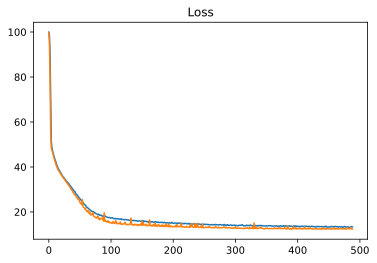

In [44]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [45]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [46]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.45%


In [47]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Что сделано для улучшения Model 3:    
* Данные для нейросети максимально преобразованы к распределению, близкому к нормальному, 

* Извлечены числовые значения из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений. <i> Результат - мощность и объем незначительно улучшили результат, а вот владение, заполненное медианой по году - немного уходшило Catboost </i>


* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные удалены. Наличие xDrive вынесено в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [48]:
data.description

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг hamman по...
2       машина продаваться первый но только перебрать ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить официальный дилер г третий владелец вла...
8350    торг место всё работать сборка немецкий резина...
8351    автомобиль отличный состояние авто семья обслу...
8352    удлинённый заводский pullman база w140 вообще ...
Name: description, Length: 8353, dtype: object

In [49]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [50]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [51]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.71 s, sys: 3.26 ms, total: 1.72 s
Wall time: 1.8 s


In [52]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'салон': 5,
 'сидение': 6,
 'состояние': 7,
 'год': 8,
 'передний': 9,
 'машина': 10,
 'диск': 11,
 'комплект': 12,
 'дилер': 13,
 'в': 14,
 'новый': 15,
 'официальный': 16,
 'ваш': 17,
 'кредит': 18,
 'фара': 19,
 'авто': 20,
 'руль': 21,
 'пакет': 22,
 'всё': 23,
 'колесо': 24,
 'безопасность': 25,
 'комплектация': 26,
 'гарантия': 27,
 'вы': 28,
 'птс': 29,
 'контроль': 30,
 'обмен': 31,
 'зеркало': 32,
 'проверка': 33,
 'bmw': 34,
 'покупка': 35,
 'продажа': 36,
 'полный': 37,
 'шина': 38,
 'водитель': 39,
 'датчик': 40,
 'отличный': 41,
 'пассажир': 42,
 'двигатель': 43,
 'резина': 44,
 'условие': 45,
 'владелец': 46,
 'ключ': 47,
 'то': 48,
 'кузов': 49,
 'подушка': 50,
 'технический': 51,
 'подогрев': 52,
 'любой': 53,
 'обслуживание': 54,
 'хороший': 55,
 'обогрев': 56,
 'км': 57,
 'два': 58,
 'юридический': 59,
 'оригинал': 60,
 'торг': 61,
 'стекло': 62,
 'масло': 63,
 'замена': 64,
 'дверь': 65,
 'пройти': 66,
 'н

In [53]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.56 s, sys: 6.45 ms, total: 1.57 s
Wall time: 1.57 s


In [54]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить пункт автокредит специальный ставка 7% ауди центр север официальный дилер audi входящий группа компания рольф являться один крупный дилер европа предлагать вы ряд услуга покупка продажа автомобиль пробег на протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние чтобы убедиться правильный выбор вы возможность пройти тест драйв ― ознакомительный поездка интересовать автомобиль вы смочь ознакомиться автомобиль выходить дом – наш менеджер провести online презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать вы хороший условие кредитование более проверить автомобиль пробег гарантия год ждать вы сайт ro

### RNN NLP

In [55]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

## Добавление transfer-learning
### Обучим отдельно только NLP часть, то есть попробуем предсказать цену только на основе описания автомобиля. Потом добавим ее в сеть с мульти входом

In [56]:
model_nlp.trainable_variables

[<tf.Variable 'embedding/embeddings:0' shape=(23535, 256) dtype=float32, numpy=
 array([[-0.02416122, -0.0220331 ,  0.03749181, ...,  0.04136251,
          0.00302088,  0.03455938],
        [ 0.03231238, -0.01823158, -0.02925642, ...,  0.04694662,
          0.00053455, -0.02432603],
        [-0.04656419, -0.04914578,  0.03207526, ...,  0.02325202,
         -0.02046799, -0.03658769],
        ...,
        [ 0.02132684,  0.01816687,  0.03712616, ...,  0.02232322,
          0.03469061,  0.04447272],
        [ 0.02747713,  0.03637136, -0.01446249, ..., -0.01845243,
         -0.04980963,  0.02201115],
        [ 0.01612708, -0.04249971,  0.04152341, ...,  0.04989905,
         -0.00795125, -0.03175253]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell/kernel:0' shape=(256, 1024) dtype=float32, numpy=
 array([[ 0.01874198,  0.02535684, -0.01333203, ...,  0.06373294,
          0.02712493, -0.03782931],
        [-0.06694405, -0.01417546,  0.03892402, ..., -0.01168802,
         -0.01878682, -0.0121

In [57]:
# сделаем голову только для NLP сети
head_nlp = L.Dense(32, activation="relu")(model_nlp.output)
head_nlp = L.Dense(1, activation="linear")(head_nlp)


In [58]:
model_nlp_only = Model(inputs=model_nlp.input, outputs=head_nlp)
model_nlp_only.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_description (InputLayer) [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 256)          6024960   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [59]:
len(model_nlp_only.trainable_variables)

13

In [60]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_nlp_only.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [61]:
checkpoint = ModelCheckpoint('../working/best_nlp_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [62]:
history = model_nlp_only.fit(text_train_sequences, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 320ms/step - loss: 99.9993 - MAPE: 99.9993 - val_loss: 99.9933 - val_MAPE: 99.9933
Epoch 2/500
12/12 [==============================] - 3s 270ms/step - loss: 99.9712 - MAPE: 99.9712 - val_loss: 99.9087 - val_MAPE: 99.9087
Epoch 3/500
12/12 [==============================] - 3s 260ms/step - loss: 99.7951 - MAPE: 99.7951 - val_loss: 99.5362 - val_MAPE: 99.5362
Epoch 4/500
12/12 [==============================] - 3s 256ms/step - loss: 99.1949 - MAPE: 99.1949 - val_loss: 98.4915 - val_MAPE: 98.4915
Epoch 5/500
12/12 [==============================] - 3s 256ms/step - loss: 97.7064 - MAPE: 97.7064 - val_loss: 96.2110 - val_MAPE: 96.2110
Epoch 6/500
12/12 [==============================] - 3s 263ms/step - loss: 94.6938 - MAPE: 94.6938 - val_loss: 91.9426 - val_MAPE: 91.9426
Epoch 7/500
12/12 [==============================] - 3s 251ms/step - loss: 89.4207 - MAPE: 89.4207 - val_loss: 84.8437 - val_MAPE: 84.8437
Epoch 8/500
12/12 [========

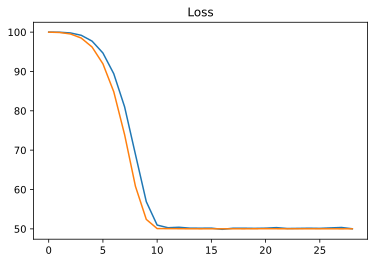

In [63]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [64]:
model_nlp_only.load_weights('../working/best_nlp_model.hdf5')
model_nlp_only.save('../working/nlp_only.hdf5')

In [65]:
test_predict_nlp_only = model_nlp_only.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nlp_only[:,0]))*100:0.2f}%")

TEST mape: 50.02%


### MLP
Дальше в мульти инпут пойдет сеть NLP не со случайными весами, а с теми, которые уже чему-то научились.

In [66]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [67]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [68]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     6024960     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [69]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [71]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 340ms/step - loss: 99.5348 - MAPE: 99.5348 - val_loss: 98.3832 - val_MAPE: 98.3832
Epoch 2/500
12/12 [==============================] - 3s 262ms/step - loss: 95.2823 - MAPE: 95.2823 - val_loss: 85.4438 - val_MAPE: 85.4438
Epoch 3/500
12/12 [==============================] - 3s 262ms/step - loss: 66.5635 - MAPE: 66.5635 - val_loss: 52.2086 - val_MAPE: 52.2086
Epoch 4/500
12/12 [==============================] - 4s 295ms/step - loss: 52.1215 - MAPE: 52.1215 - val_loss: 47.6508 - val_MAPE: 47.6508
Epoch 5/500
12/12 [==============================] - 3s 252ms/step - loss: 48.4310 - MAPE: 48.4310 - val_loss: 44.8960 - val_MAPE: 44.8960
Epoch 6/500
12/12 [==============================] - 3s 258ms/step - loss: 44.9972 - MAPE: 44.9972 - val_loss: 42.8552 - val_MAPE: 42.8552
Epoch 7/500
12/12 [==============================] - 3s 274ms/step - loss: 42.1318 - MAPE: 42.1318 - val_loss: 40.8426 - val_MAPE: 40.8426
Epoch 8/500
12/12 [========

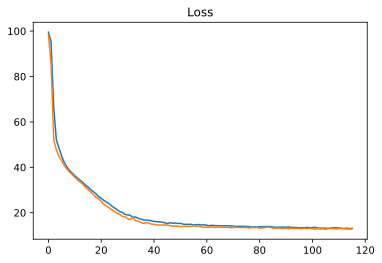

In [72]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [74]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.85%


In [75]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [76]:
# blend 
blend_predict_2 = (np.exp(test_predict_catboost) + test_predict_nn1[:,0] + test_predict_nn2[:,0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict_2))*100:0.2f}%")

TEST mape: 11.18%


In [77]:
print(f"TEST mape: {(mape(y_test, blend_predict_2))*100:0.2f}%")

TEST mape: 11.18%


In [78]:
sub_blend_predict_2 = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn2[:,0]) / 3
sub_blend_predict_2 = sub_blend_predict_2 * 10000 // 10000
sample_submission['price'] = sub_blend_predict_2
sample_submission.to_csv('blend2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив  - не сделано, только в табличной сети это учтено
* Сделана предобработка текста - лемматизация, алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста: текст очищен от стоп-слов

# Model 5: Добавляем картинки

### Data

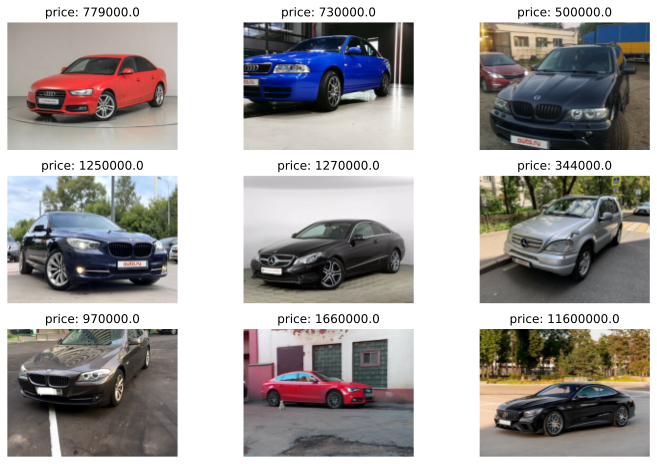

In [79]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [80]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

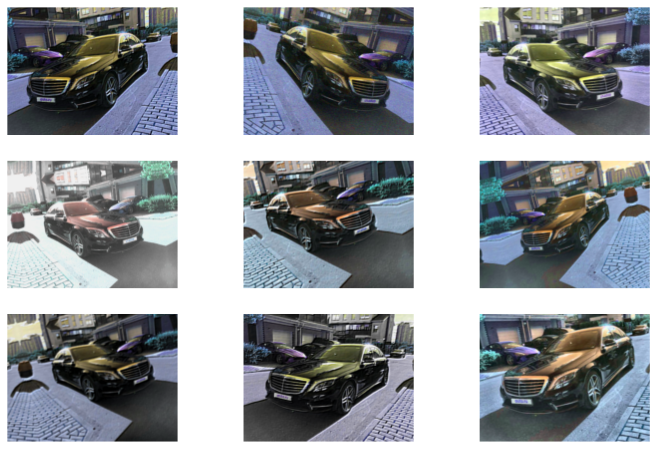

In [81]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.9),
    HueSaturationValue(p=0.9), # добавим больше изменений по цветам
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[9])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [82]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [83]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [84]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [85]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


#### Сделаем предобучение нейросети для картинок

In [86]:
def tf_process_train_dataset_element_eff(image, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image), price

def tf_process_val_dataset_element_eff(image, price):
    return (image), price


In [87]:
# датасеты для тренировки только изображений
# для ускорения работы и получения минимально работающего пайплайна, воспользуюсь готовым решением и исключу из подготовленных 
# в бейзлайне функций обработку текста и таблиц. 
train_dataset_eff = tf.data.Dataset.from_tensor_slices((
    images_train, y_train
    )).map(tf_process_train_dataset_element_eff)

test_dataset_eff = tf.data.Dataset.from_tensor_slices((
    images_test, y_test
    )).map(tf_process_val_dataset_element_eff)

y_sub_eff = np.zeros(len(X_sub))
sub_dataset_eff = tf.data.Dataset.from_tensor_slices((
    images_sub, y_sub
    )).map(tf_process_val_dataset_element_eff)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset_eff.__iter__().__next__();
test_dataset_eff.__iter__().__next__();
sub_dataset_eff.__iter__().__next__();

In [88]:
efficientnet_output

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1536) dtype=float32>

In [89]:
# сделаем голову для сети, обрабатывающей только изображения
head_eff = L.Dense(256, activation='relu')(efficientnet_output)
#head_eff = L.BatchNormalization()(head_eff)
head_eff = L.Dropout(0.2)(head_eff)
# predictions
head_eff = L.Dense(1, activation="linear")(head_eff)

In [90]:
model_eff_only = Model(inputs=efficientnet_model.input, outputs=head_eff)
model_eff_only.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [91]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_eff_only.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [92]:
checkpoint = ModelCheckpoint('../working/best_eff_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [93]:
history = model_eff_only.fit(train_dataset_eff.batch(30),
                    epochs=100,
                    validation_data = test_dataset_eff.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 129s 681ms/step - loss: 74.5051 - MAPE: 74.5051 - val_loss: 393271.1562 - val_MAPE: 393271.1562
Epoch 2/100
190/190 [==============================] - 128s 673ms/step - loss: 50.0837 - MAPE: 50.0837 - val_loss: 49.9158 - val_MAPE: 49.9158
Epoch 3/100
190/190 [==============================] - 131s 691ms/step - loss: 49.8808 - MAPE: 49.8808 - val_loss: 57.4429 - val_MAPE: 57.4429
Epoch 4/100
190/190 [==============================] - 128s 675ms/step - loss: 49.8873 - MAPE: 49.8873 - val_loss: 51.5447 - val_MAPE: 51.5447
Epoch 5/100
190/190 [==============================] - 127s 671ms/step - loss: 49.7668 - MAPE: 49.7668 - val_loss: 49.7243 - val_MAPE: 49.7243
Epoch 6/100
190/190 [==============================] - 124s 655ms/step - loss: 49.5944 - MAPE: 49.5944 - val_loss: 50.2604 - val_MAPE: 50.2604
Epoch 7/100
190/190 [==============================] - 125s 659ms/step - loss: 49.7258 - MAPE: 49.7258 - val_loss: 54.5061 - val_MAPE:

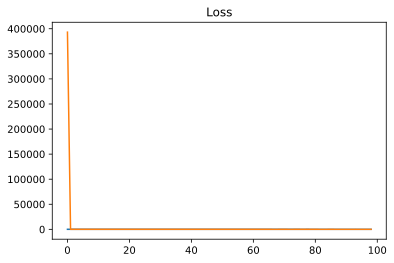

In [94]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [95]:
model_eff_only.load_weights('../working/best_eff_model.hdf5')
model_eff_only.save('../working/eff_only.hdf5')

#### Вывод по обучению сети на основе изображений:
результат порядка MAPE = 33% для предсказания цены по фото гораздо лучше 50%, полученных для предсказания цены только по описанию. То есть, можно предположить, что нейросеть выявила какие-то полезные признаки, которые будем дальше использовать в мульти-инпут сети

## Объединим три сети (таблица, текст и изображения)
При этом воспользуемся fine-tuning - возьмем обученную на предыдущем шаге нейросеть, и дальше будем изменять веса только для второй половины (первую половину "заморозим")

In [96]:
len(efficientnet_model.trainable_variables)

338

In [97]:
#настроим нейросеть для анализа изображений
efficientnet_model.trainable = True
fine_tune_at = 170
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable = False
len(efficientnet_model.trainable_variables)

190

In [98]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [99]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [100]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [101]:
optimizer = tf.keras.optimizers.Nadam(0.005) # поменяем на Надам для разнообразия
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [102]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [103]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 128s 672ms/step - loss: 48.0405 - MAPE: 48.0405 - val_loss: 32.6012 - val_MAPE: 32.6012
Epoch 2/100
190/190 [==============================] - 122s 644ms/step - loss: 30.4065 - MAPE: 30.4065 - val_loss: 27.1741 - val_MAPE: 27.1741
Epoch 3/100
190/190 [==============================] - 117s 615ms/step - loss: 26.8023 - MAPE: 26.8023 - val_loss: 23.4885 - val_MAPE: 23.4885
Epoch 4/100
190/190 [==============================] - 116s 609ms/step - loss: 23.4830 - MAPE: 23.4830 - val_loss: 21.7744 - val_MAPE: 21.7744
Epoch 5/100
190/190 [==============================] - 119s 626ms/step - loss: 20.9189 - MAPE: 20.9189 - val_loss: 18.7673 - val_MAPE: 18.7673
Epoch 6/100
190/190 [==============================] - 119s 628ms/step - loss: 19.0578 - MAPE: 19.0578 - val_loss: 18.3727 - val_MAPE: 18.3727
Epoch 7/100
190/190 [==============================] - 120s 633ms/step - loss: 17.6840 - MAPE: 17.6840 - val_loss: 15.8249 - val_MAPE: 15.8249

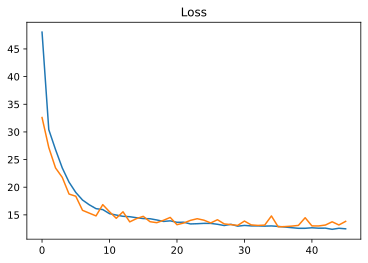

In [104]:
# выводы по файн тюнингу - ошибка без предобучения начиналась от 55%, а с предобучением - от 33%, 
# то есть предварительное обучение нейросети для анализа изображений помогает

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [105]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [106]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.83%


In [107]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [108]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.89%


In [109]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [110]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [111]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [112]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [113]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_17_input (InputLayer)     [(None, 232)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 512)          119296      dense_17_input[0][0]             
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 512)          0           dense_17[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [114]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [115]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 26ms/step - loss: 99.9790 - MAPE: 99.9790 - val_loss: 99.7743 - val_MAPE: 99.7743
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 98.1605 - MAPE: 98.1605 - val_loss: 92.1776 - val_MAPE: 92.1776
Epoch 3/500
12/12 [==============================] - 0s 9ms/step - loss: 75.9490 - MAPE: 75.9490 - val_loss: 49.6618 - val_MAPE: 49.6618
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 52.9310 - MAPE: 52.9310 - val_loss: 47.8473 - val_MAPE: 47.8473
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 47.5123 - MAPE: 47.5123 - val_loss: 45.3436 - val_MAPE: 45.3436
Epoch 6/500
12/12 [==============================] - 0s 10ms/step - loss: 44.9686 - MAPE: 44.9686 - val_loss: 43.1532 - val_MAPE: 43.1532
Epoch 7/500
12/12 [==============================] - 0s 9ms/step - loss: 42.5114 - MAPE: 42.5114 - val_loss: 41.1363 - val_MAPE: 41.1363
Epoch 8/500
12/12 [====================

In [116]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.98%


In [117]:
# 